In [1]:
from dotenv import load_dotenv

load_dotenv()

True

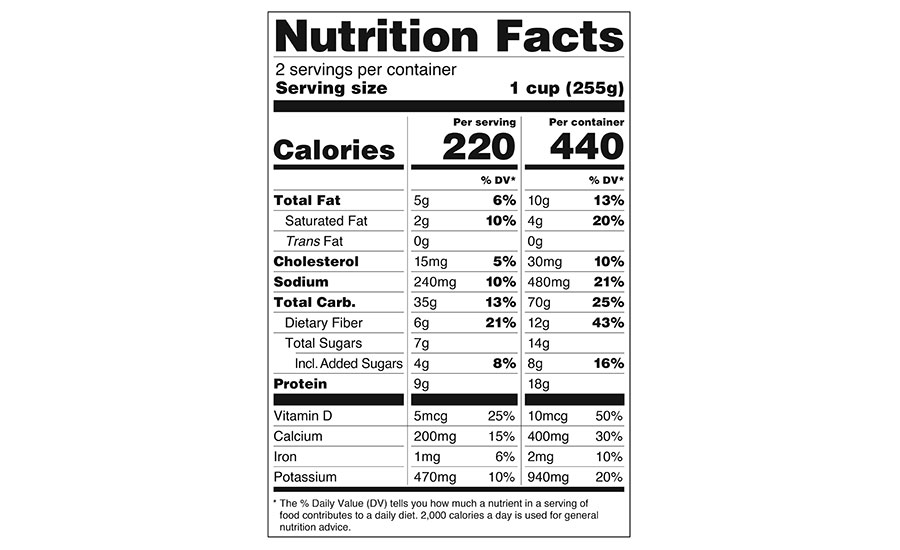

In [2]:
from IPython.display import Image, display, Audio, Markdown
import base64

IMAGE_PATH = "data/nutrition_2.png"

# Preview image for context
display(Image(IMAGE_PATH))

In [3]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

In [4]:
from typing import Optional
from sqlmodel import Field, SQLModel, create_engine , Session
import instructor
from pydantic import BaseModel
from openai import OpenAI


# Define your desired output structure
class NutritionInfo(SQLModel, instructor.OpenAISchema, table=True):
    id: Optional[int] = Field(default=None, primary_key=True)
    serving_size: str
    servings_per_container: int
    calories_per_serving: int
    total_fat_per_serving: str
    sodium_per_serving: str
    total_carbohydrate_per_serving: str
    protein_per_serving: str

In [5]:
# Patch the OpenAI client
client = instructor.from_openai(OpenAI())

# Extract structured data from natural language

def get_nutrition() -> NutritionInfo:
    return client.chat.completions.create(
    model="gpt-4o",
    response_model=NutritionInfo,
    messages=[
        {"role": "system", "content": "You are a nutrition expert that will extract the nutrition information from the nutrition label"},
        {"role": "user", "content": [
            {"type": "text", "text": "Whats the nutrition?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"
            }}
        ]}
    ]
)


In [6]:
engine = create_engine("sqlite:///database.db")
SQLModel.metadata.create_all(engine)

nutrition = get_nutrition()
print(nutrition.model_dump())


with Session(engine) as session:
    session.add(nutrition)
    session.commit()

{'serving_size': '1 cup (255g)', 'servings_per_container': 2, 'calories_per_serving': 220, 'total_fat_per_serving': '5g', 'sodium_per_serving': '240mg', 'total_carbohydrate_per_serving': '35g', 'protein_per_serving': '9g', 'id': None}


In [7]:
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core import SQLDatabase


sql_database = SQLDatabase(engine, include_tables=["nutritioninfo"])



In [10]:
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.llms.openai import OpenAI
from llama_index.core.retrievers import NLSQLRetriever


llm = OpenAI(temperature=0.1, model="gpt-3.5-turbo")


nl_sql_retriever = NLSQLRetriever(
    sql_database, tables=["nutritioninfo"], return_raw=True
)

In [20]:
from llama_index.core.query_engine import RetrieverQueryEngine

query_engine = RetrieverQueryEngine.from_args(nl_sql_retriever)

response = query_engine.query(
    "calculate my total calorie"
)

In [19]:
print(str(response))

Multiply the number of servings by the calories per serving to calculate the total calorie count.
